# **Project 5 - Vehicle Detection and Tracking**

## **Detecting vehicles in images using a Scikit Learn classifier**

In [1]:
# Importing libraries
import os
import glob
import time
import pickle

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from scipy.ndimage.measurements import label

%matplotlib inline

In [2]:
# Retrieving saved model
pickle_name = './model_backup/model.pickle'

if os.path.isfile(pickle_name):
    # Getting pickle file
    with open(pickle_name, 'rb') as f:
        pickle_file = pickle.load(f)
    
    print('Model retrieved from pickle file.')
    
else:
    print('Model not saved yet.')

Model retrieved from pickle file.


## **1. Building training set**

Here we are extracting sample images of **vehicles** and "**non-vehicles**". All sample images are **64x64** pixels.
Those images are mostly coming from the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html) and the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/).

8792 images of cars with shape (64, 64, 3)


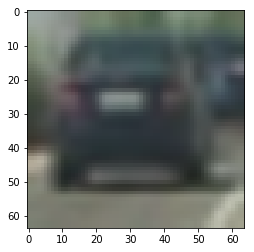

In [3]:
# Initializing array of images
if 'pickle_file' in locals():
    # Retrieving images from saved model
    cars = pickle_file['cars_images']
    
else:
    cars = []

    # Browsing image files in folder
    for img_name in glob.glob('./train_images/vehicles/**/*.png'):
        # Appending array of images
        cars.append(mpimg.imread(img_name))

# Printing number and shape of images
print('{} images of cars with shape {}'.format(len(cars), cars[0].shape))

# Testing
plt.imshow(cars[0])

8968 images of other objects with shape (64, 64, 3)


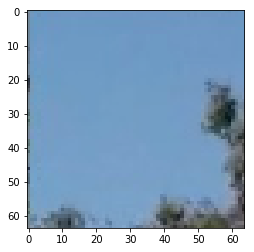

In [4]:
# Initializing array of images
if 'pickle_file' in locals():
    # Retrieving images from saved model
    non_cars = pickle_file['non_cars_images']
    
else:
    non_cars = []

    # Browsing image files in folder
    for img_name in glob.glob('./train_images/non-vehicles/**/*.png'):
        # Appending array of images
        non_cars.append(mpimg.imread(img_name))
        
# Printing number and shape of images
print('{} images of other objects with shape {}'.format(len(non_cars), non_cars[0].shape))

# Testing
plt.imshow(non_cars[0])

After looking at images, it does not look like **data augmentation** such as translation or rotation is required here, since the same image is often repeated from various points of view. Example here below:

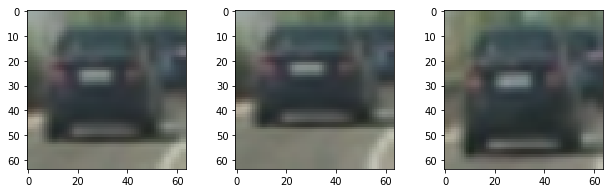

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 8))
f.tight_layout()

ax1.imshow(cars[0])
ax2.imshow(cars[1])
ax3.imshow(cars[2])

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## **2. Extracting features from images**

The key component here is our feature extraction process, which relies on the three following functions:

- **bin_spatial**: this function transforms images into a flat vector of pixel values. As a result, it focuses on spatial features, i.e. **where** objects are located in images. 


- **color_hist**: for each color channel, this function stacks pixel values in histograms. So it insists on the relative intensity of **colors** with respect to each other. The underlying assumption here is that vehicles detach themselves from the background thanks to their color. Depending on the selected **color space**, this method captures different color characteristics. For example, under the HLS space, vehicles will probably distinguish themselves from the background thanks to more saturated colors (S channel).


- **get_hog_features**: this function relies on the [HOG function](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog), for "Histogram Oriented Gradient", from the scikit-image library. This method consists in computing gradient orientation for different regions of images (8x8 pixel blocks in our model) and assigning the output to histograms. After experimenting different values, we chose **nine target bins** for the different gradient orientations. This function is probably the closest to human eyes in our recognition process, since it focuses on **shapes**.

The **extract_features** function combines the three aforementioned functions to build a flat **feature vector** as an **image signature**, to be fed to our classifier.

Finally, the **extract_features_all** function applies our feature extraction process to all images from the training set: 
- To "**car**" images. Car images are assigned the **1 label**.
- To "**non-car**" images. Non-car images are assigned the **0 label**

All extracted features are then **normalized** using the Scikit Learn **Standard Scaler**.

### **2.1 Defining feature extraction functions**

Here we are defining feature extraction functions.

In [6]:
# To compute binned color features  
def bin_spatial(img, size=(32, 32)):
    import cv2
    # Using cv2.resize().ravel() to create feature vector
    features = cv2.resize(img, size).ravel()
    return features

# To compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    import numpy as np
    # Computing histogram of color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenating histograms into single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# To visualize color histograms
def color_hist_vis(img, nbins=32, bins_range=(0, 256)):
    import numpy as np
    # Computing histogram of color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist, bin_centers

# To compute HOG features and visualization
def get_hog_features(img, orient_bins, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    from skimage.feature import hog
    
    # Returning two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient_bins, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise one output
    else:      
        features = hog(img, orientations=orient_bins, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# To extract features from one image
def extract_features(img, color_space='RGB', spatial_size=(32, 32), 
                        hist_bins=32, orient_bins=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channels=0, 
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    import numpy as np
    import cv2
    
    # Create a feature vectors
    features_one = []

    # Applying color conversion
    if color_space != 'RGB':
        feature_image = cv2.cvtColor(img, eval('cv2.COLOR_RGB2' + color_space))
    else:
        feature_image = np.copy(image)
        
    # Getting binned color features
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        features_one.append(spatial_features)
    
    # Getting color histogram features 
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        features_one.append(hist_features)
    
    # Getting HOG features for selected channel(s)
    if hog_feat == True:
        if hog_channels == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient_bins, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channels], orient_bins, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Appending new feature vector to list
        features_one.append(hog_features)
        
    # Returning list of feature vectors
    return np.concatenate(features_one)

In [7]:
# To extract features from list of images
def extract_features_all(imgs, color_space='RGB', spatial_size=(32, 32), 
                        hist_bins=32, orient_bins=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channels=0, 
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    import numpy as np
    import cv2
    
    # Creating list of feature vectors
    features = []
    
    # Browsing images
    for img in imgs:
        # Extracting features from image
        features_one = extract_features(img, color_space=color_space, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient_bins=orient_bins, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channels=hog_channels, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        # Appending to list of feature vectors
        features.append(features_one)
        
    # Returning list
    return features

### **2.2 Visualizing color histograms and histograms of oriented gradients**

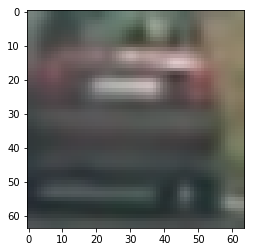

In [8]:
# Getting and visualizing test image
img = np.array(255 * cars[129]).astype(np.uint8)
plt.imshow(img)

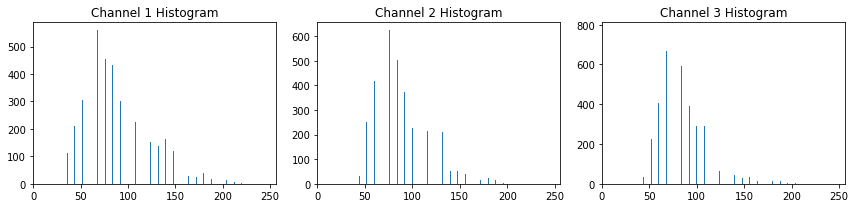

In [9]:
# Visualizing color_hist ouput for each color channel (RGB in this example)

# Calling function
channel1_hist, channel2_hist, channel3_hist, bin_centers = color_hist_vis(img, nbins=32, bins_range=(0, 256))

# Plotting result
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, channel1_hist[0])
plt.xlim(0, 256)
plt.title('Channel 1 Histogram')
plt.subplot(132)
plt.bar(bin_centers, channel2_hist[0])
plt.xlim(0, 256)
plt.title('Channel 2 Histogram')
plt.subplot(133)
plt.bar(bin_centers, channel3_hist[0])
plt.xlim(0, 256)
plt.title('Channel 3 Histogram')
fig.tight_layout()

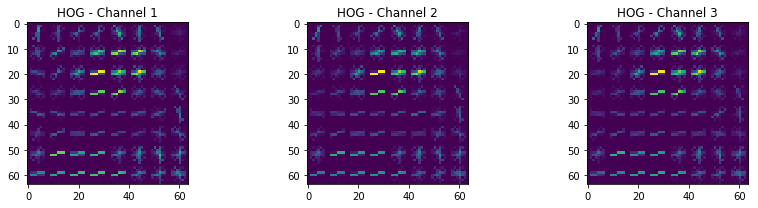

In [10]:
# Calling function and plotting result
img_hog1 = get_hog_features(img[:,:,0], orient_bins=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
img_hog2 = get_hog_features(img[:,:,1], orient_bins=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
img_hog3 = get_hog_features(img[:,:,2], orient_bins=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)

# Plotting result
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(img_hog1[1])
plt.title('HOG - Channel 1')
plt.subplot(132)
plt.imshow(img_hog2[1])
plt.title('HOG - Channel 2')
plt.subplot(133)
plt.imshow(img_hog3[1])
plt.title('HOG - Channel 3')
fig.tight_layout()

### **2.3 Extracting features from images**

After multiple iterations, we are retaining the following parameters as optimal for feature extraction:

- Color space: '**YCrCb**' (color_space variable)
- Spatial size for spatial binning: **16x16** (spatial_size variable)
- Number of bins for color histograms: **32** (hist_bins variable)
- Number of bins for gradient orientation (HOG features): **9** (orient_bins variable)
- Number of pixels per cell for HOG features: **8** (pix_per_cell variable)
- Number of cells per block of cells for HOG features: **2** (cell_per_block variable)
- Color channels selected for HOG features: **All** (hog_channels variables)

In [11]:
if 'pickle_file' in locals():
    # Retrieving model from saved pickle file
    color_space = pickle_file['color_space']
    spatial_size = pickle_file['spatial_size']
    hist_bins = pickle_file['hist_bins']
    orient_bins = pickle_file['orient_bins']
    pix_per_cell = pickle_file['pix_per_cell']
    cell_per_block = pickle_file['cell_per_block']
    hog_channels = pickle_file['hog_channels']
    
    print('Retrieving feature extraction parameters from pickle file.')
    
else:
    
    # Extracting features from vehicle and non-vehicle images
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    spatial_size = (16, 16)
    hist_bins = 32
    orient_bins = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channels = 'ALL' #Can be 0, 1, 2, or "ALL"

    t = time.time()
    cars_features = extract_features_all(cars, color_space=color_space, spatial_size=spatial_size, 
                            hist_bins=hist_bins, orient_bins=orient_bins, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channels=hog_channels)

    non_cars_features = extract_features_all(non_cars, color_space=color_space, spatial_size=spatial_size, 
                            hist_bins=hist_bins, orient_bins=orient_bins, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channels=hog_channels)

    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...')
    print('Feature vector length:', len(cars_features[0]))

Retrieving feature extraction parameters from pickle file.


In [12]:
if 'pickle_file' in locals():
    # Retrieving model from saved pickle file
    X = np.concatenate((pickle_file['X_train'], pickle_file['X_test']))
    y = np.concatenate((pickle_file['y_train'], pickle_file['y_test']))
    X_scaler = pickle_file['scaler']
    
    print('Retrieving features, labels and scaler from pickle file.')

else:
    # Creating array stack of feature vectors
    X = np.vstack((cars_features, non_cars_features)).astype(np.float64)
    
    # Defining labels vector: 1 for cars, 0 for non-cars
    y = np.hstack((np.ones(len(cars_features)), np.zeros(len(non_cars_features))))

    # Fitting scaler
    X_scaler = StandardScaler().fit(X)

# Applying scaler to X
scaled_X = X_scaler.transform(X)    

print('{} images in training set'.format(len(X)))
print('{} labels in training set'.format(len(y)))

Retrieving features, labels and scaler from pickle file.
17760 images in training set
17760 labels in training set


## **3. Building vehicle / non-vehicle classifier**

In this section we are:
- Splitting the training set between **training** and **test** images
- **Training** a Support Vector Machine classifier: after comparing a Naive Bayes and SVM classifier, we concluded that the **SVM** offered the best combination of accuracy and execution speed.
- **Testing** our classifier
- **Saving** our classifier along with feature extraction parameters to a pickle file, for further use

### **3.1 Training classifier**

In [13]:
if 'pickle_file' in locals():
    # Retrieving model from saved pickle file
    X_train = pickle_file['X_train']
    X_test = pickle_file['X_test']
    y_train = pickle_file['y_train']
    y_test = pickle_file['y_test']
    clf = pickle_file['classifier']
    
    print('Retrieving training set, test set and classifier from pickle file.')
    
else:

    # Splitting data between training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    
    # Selecting linear SVC as classifier
    clf = LinearSVC()

    # Training classifier
    t = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train classifier.')
    
print('Parameters:', 
      color_space, 'color space, ', 
      spatial_size, 'spatial size, ', 
      hist_bins, 'color bins, ', 
      orient_bins,'orientation bins, ', 
      pix_per_cell, 'pixels per cell, ', 
      cell_per_block, 'cells per block and', 
      hog_channels, 'HOG channel(s)')

print('Feature vector length:', len(X_train[0]))

# Check classifier's accuracy
print('Test accuracy of classifier = {0:.1%}'.format(clf.score(X_test, y_test)))

Retrieving training set, test set and classifier from pickle file.
Parameters: YCrCb color space,  (16, 16) spatial size,  32 color bins,  9 orientation bins,  8 pixels per cell,  2 cells per block and ALL HOG channel(s)
Feature vector length: 6156
Test accuracy of classifier = 98.8%


### **3.2 Testing classifier**

In [14]:
# Checking predictions on test set
t = time.time()
n_predict = 15
predictions = clf.predict(X_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels')

if n_predict <= 15:
    print('Fredictions: ', predictions)
    print('For the following ', n_predict, 'labels: ', y_test[0:n_predict])

acc = accuracy_score(predictions, y_test[0:n_predict])
print('Accuracy on test set: {0:.1%}'.format(acc))

0.001 Seconds to predict 15 labels
Fredictions:  [ 0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  1.]
For the following  15 labels:  [ 0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  1.]
Accuracy on test set: 100.0%


### **3.3 Saving data for further use**

In [15]:
# Saving training images, training features, parameters and scaler 
if not os.path.isfile(pickle_name):
    with open(pickle_name, 'wb') as pfile:
        pickle.dump(
            {
                'cars_images': cars, 
                'non_cars_images': non_cars, 
                'color_space': color_space, 
                'spatial_size': spatial_size, 
                'hist_bins': hist_bins, 
                'orient_bins': orient_bins, 
                'pix_per_cell': pix_per_cell, 
                'cell_per_block': cell_per_block, 
                'hog_channels': hog_channels, 
                'X_train': X_train, 
                'y_train': y_train, 
                'X_test': X_test, 
                'y_test': y_test, 
                'scaler': X_scaler, 
                'classifier': clf
            },
            pfile, pickle.HIGHEST_PROTOCOL)
    
    print('File saved at {}.'.format(pickle_name))
    
else:
    print('Model already saved.')

Model already saved.


## **4. First approach for vehicle detection**

For a given image from a video stream, the approach consists in:

- Focusing on the **lower portion** of the image as a region of interest, where cars are more likely to appear.


- Dividing the region of interest into **windows** of different sizes: the **higher** in the region of interest, i.e. the **further** from our camera point of view, the **smaller** the scale. Windows are built byt the **slide_window** function.


- Scanning **each window**, resizing it to 64x64 (size of images in training set) and run our **classifier** to detect cars or not. If our classifier returns a **positive detection** (label=1), we are appending the window to a list of positive detections. This is achieved by the **search_windows** function.


- **Drawing** all positive windows on the image, using the **draw_boxes** function.

After getting all windows with positive detections, we are filtering out **false positives** and merging **duplicates**. This is achieved by the **bounding_boxes** function, as following:

- Initializing a **heat map**, with the same size as the original image, featuring **zeros** for each pixel position.


- Iterating through positive windows and accumulating 1 for each pixel position within windows. This is achieved by the **add_heat** function. The same car is usually detected **several times** by different windows. So when there truly is a car, windows are **overlapping**, which results in pixel positions assigned with **more than 1** as a tag.


- Retaining only pixel positions above a given threshold, using the **apply_threshold** function. This step normally gets rid of **false positives**, since they usually are not "detected" more than once or a limited amount of times.


- **Merging windows**: this step relies on the **label** function from the **scipy.ndimage.measurements** library ([link](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html)). The Scikit documentation does not explain the underlying theory, so checking this [link](https://en.wikipedia.org/wiki/Connected-component_labeling)  might be helpful here. Essentially, the label function allows connecting **adjacent regions** on a given map: each region with common pixels is considered a "label". We are leveraging this function to connect overlapping windows together. Then we use our **draw_labeled_bboxes** function to retain only minimum and maximum x and y pixel positions, which result in merging overlapping windows.

### **4.1 Defining functions to scan images with search windows**

In [16]:
# To add zeros to file name (for troubleshooting)
def addzeros(number, n_zeros):
    output = str(number)
    for i in range(n_zeros-len(str(number))):
        output = '0' + output
    return output

In [17]:
# To slide search window on image
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, setting to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Computing span of region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Computing number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Computing number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.max((1, np.int((xspan-nx_buffer)/nx_pix_per_step)), axis=0)
    ny_windows = np.max((1, np.int((yspan-ny_buffer)/ny_pix_per_step)), axis=0)
    
    # Initializing list of window positions
    window_list = []
    
    # Loop through windows
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculating window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Appending window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Returning list of windows
    return window_list

# To search cars in sliding windows using classifier
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(16, 16), hist_bins=32, 
                    hist_range=(0, 256), orient_bins=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channels=0, 
                    spatial_feat=True, hist_feat=True, hog_feat=True, 
                    save_window=False):
    
    # Creating list of windows with positive detection
    on_windows = []
    
    # Iterating over windows
    c = 0
    for window in windows:
        c += 1
        
        # Extracting test window from original image
        test_img = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        
        # Resizing to match training set
        test_img = cv2.resize(test_img, (64, 64))
        
        # Normalixing pixels in window
        test_img = test_img.astype(np.float32) / 255
        
        # Extracting features from window
        features = extract_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient_bins=orient_bins, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channels=hog_channels, 
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        # Scaling extracted features
        features_scaled = scaler.transform(np.array(features).reshape(1, -1))
        
        # Predicting using classifier
        prediction = clf.predict(features_scaled)
        
        # Saving window when positive prediction (=1)
        if prediction == 1:
            on_windows.append(window)
            
            # Saving window image for troubleshooting
            if save_window:
                c += 1
                fname = addzeros(c, 4) + '.png'
                mpimg.imsave('./add_images/' + fname, test_img)
    
    # Returning windows with positive detections
    return on_windows


# To draw bounding boxes on image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Making copy of image
    imcopy = np.copy(img)
    
    # Iterating through boxes
    for bbox in bboxes:
        # Drawing rectangle given box coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    # Returning image with boxes drawn
    return imcopy

### **4.2 Defining functions to filter false positives and merge duplicates**

In [18]:
# To initialize a heat map
def init_heat(img):
    import numpy as np
    return np.zeros_like(img[:,:,0]).astype(np.float)

# To define a heat map as ones for each pixel within boxes
def add_heat(heatmap, bbox_list):
    # Iterating boxes
    for box in bbox_list:
        # Adding 1 for all pixels inside box
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Returning heatmap
    return heatmap# Iterate through list of bboxes
    
# To retain pixels above heat threshold
def apply_threshold(heatmap, threshold):
    # Zeroing out pixels below threshold
    heatmap[heatmap <= threshold] = 0
    
    # Returning thresholded map
    return heatmap

# To draw final bounding boxes
def draw_labeled_bboxes(img, labels, color=(0, 255, 0), thick=6):
    # Iterating through all detected cars
    for car_number in range(1, labels[1]+1):
        # Finding pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identifying x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Defining bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Drawing box on image
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    
    # Returning image
    return img

# To remove duplicates and merge windows
def bounding_boxes(img, windows, threshold=1, plot_image=False):
    import numpy as np
    from scipy.ndimage.measurements import label
    
    # Initializing heat map with zeros
    heat = init_heat(img)
    
    # Adding heat to each box in list
    heat = add_heat(heat, windows)
    
    # Applying threshold to remove false positives
    heat = apply_threshold(heat, threshold)
    
    # Visualizing heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Connecting adjacent cells on heat map using label function
    labels = label(heatmap)
    
    # Rebuilding boxes based on label function
    img_draw = draw_labeled_bboxes(np.copy(img), labels)
    
    # Plotting result
    if plot_image:
        fig = plt.figure(figsize=(8, 8))
        plt.subplot(121)
        plt.imshow(img_draw)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
        
    # Returning image with merged windows
    return img_draw

### **4.3 Defining windows for search**

In [19]:
img_test = mpimg.imread('test_images/test1.jpg')

#windows = slide_window(img_test, x_start_stop=[300, 980], y_start_stop=[380, 450], xy_window=(32, 32), xy_overlap=(0.75, 0.75))
windows = slide_window(img_test, x_start_stop=[None, None], y_start_stop=[400, 500], xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows += slide_window(img_test, x_start_stop=[None, None], y_start_stop=[400, 500], xy_window=(144, 144), xy_overlap=(0.75, 0.75))
windows += slide_window(img_test, x_start_stop=[None, None], y_start_stop=[430, 550], xy_window=(192, 192), xy_overlap=(0.75, 0.75))
windows += slide_window(img_test, x_start_stop=[None, None], y_start_stop=[500, 650], xy_window=(192, 192), xy_overlap=(0.75, 0.75))

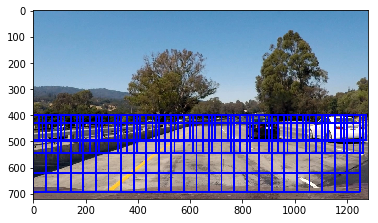

In [20]:
# Getting test image
img_test = mpimg.imread('test_images/test1.jpg')
img_draw = np.copy(img_test)

# Visualizing search windows on test image
img_window = draw_boxes(img_draw, windows, color=(0, 0, 255), thick=6)        
plt.imshow(img_window)

### **4.4 Scanning image with sliding windows**

0.63 Seconds to process image...


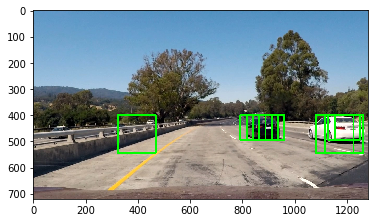

In [21]:
t = time.time()

# Searching for cars using sliding windows
hot_windows = search_windows(img_test, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient_bins=orient_bins, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channels=hog_channels, 
                        spatial_feat=True, hist_feat=True, hog_feat=True)

# Drawing windows with positive detections
img_boxes = draw_boxes(img_draw, hot_windows, color=(0, 255, 0), thick=6)        
t2 = time.time()
print(round(t2-t, 2), 'Seconds to process image...')

# Plotting result
plt.imshow(img_boxes)

### **4.5 Removing false positives and merging duplicates**

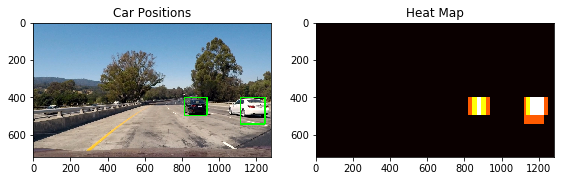

In [22]:
# Applying bounding_boxes function
img_draw = bounding_boxes(img_test, hot_windows, threshold=1, plot_image=True)

## **5. Alternative approach **

This approach is very similar to the previous one. We are still scanning images with a sliding window, but this time our **find_cars** function allows **mutualizing the computation of HOG features** instead of computing them for each individual window.

The find_cars function does not require generating search windows beforehand. It **calculates windows** dynamically, given an incremental step from a window to the next (cells_per_step argument).

Also, our function allows applying a different scale to different regions of images.

### **5.1 Defining search functions**

In [23]:
# To convert image to different color space
def convert_color(img, color_space='YCrCb'):
    import cv2
    if color_space != 'RGB':
        feature_image = cv2.cvtColor(img, eval('cv2.COLOR_RGB2' + color_space))
    else:
        feature_image = np.copy(image)
    return feature_image

# To optimize HOG feature computation
def find_cars(img, 
              y_start_stops, 
              scales, 
              clf, scaler, 
              color_space='YCrCb', 
              orient_bins=9, 
              pix_per_cell=8, cell_per_block=2, 
              cells_per_step=2, 
              spatial_size=(16,16), 
              hist_bins=32, 
              box_color=(0,255,0), 
              box_thick=6):
    
    # Copying image
    draw_img = np.copy(img)
    
    # Converting to different color space
    img = convert_color(img, color_space=color_space)
    
    # Normalizing image
    img = img.astype(np.float32)/255
    
    # Iterating through regions of interest
    on_windows = []
    for k in range(len(y_start_stops)):
        y_start_stop = y_start_stops[k]
        
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]

        # Extracting region of interest
        img_tosearch = img[y_start_stops[k][0]:y_start_stops[k][1],:,:]
        
        # Scaling region of interest
        scale = scales[k]
        if scale != 1:
            imshape = img_tosearch.shape
            ctrans_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        # Extracting individual color channels
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
        
        # Defining search blocks
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        #nfeat_per_block = orient_bins*cell_per_block**2
        
        # 
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
        # Computing HOG features for individual color channels
        hog1 = get_hog_features(ch1, orient_bins, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient_bins, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient_bins, pix_per_cell, cell_per_block, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                
                # Extracting HOG for window
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extracting image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Getting color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scaling features
                test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                
                # Making prediction
                test_prediction = clf.predict(test_features)
                
                # Saving window when positive prediction (=1)
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    on_windows.append(((xbox_left, ytop_draw+y_start_stop[0]), (xbox_left+win_draw, ytop_draw+win_draw+y_start_stop[0])))
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+y_start_stop[0]),(xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0]),box_color,box_thick) 
    
    # Returning windows with positive detections
    return on_windows

### **5.2 Scanning test image**

In [24]:
# Getting test image
img_test = mpimg.imread('test_images/test1.jpg')
img_draw = np.copy(img_test)

1.15 Seconds to process image...


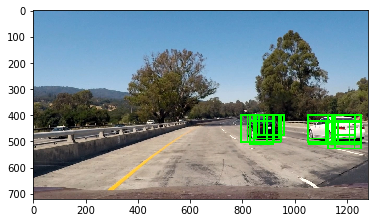

In [25]:
t = time.time()

# Searching for cars using sliding windows
hot_windows = find_cars(img_test, 
              y_start_stops=[[380, 450], [400, 500], [400, 550], [400, 660]], 
              scales=[0.8, 1.2, 1.4, 1.6], 
              clf=clf, scaler=X_scaler, 
              color_space='YCrCb', 
              orient_bins=orient_bins, 
              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
              cells_per_step=2, 
              spatial_size=spatial_size, 
              hist_bins=hist_bins)

# Drawing windows with positive detections
img_boxes = draw_boxes(img_draw, hot_windows, color=(0, 255, 0), thick=6)        
t2 = time.time()
print(round(t2-t, 2), 'Seconds to process image...')

# Plotting result
plt.imshow(img_boxes)

### **5.3 Removing false positives and merging duplicates**

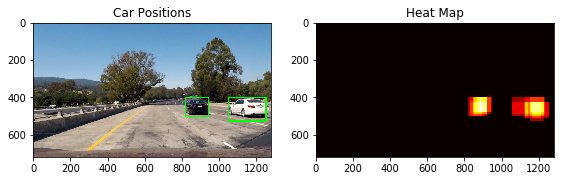

In [26]:
# Applying bounding_boxes function
img_draw = bounding_boxes(img_test, hot_windows, threshold=1, plot_image=True)

## **6. Implementing final pipeline**

According to test images (see below), our **alternative method** seems to do a better job at **detecting** cars, removing **false detections**, as well as **fitting** cars in boxes.

It is mostly due to our **variable scales** that are better tailored to the different regions of images.

As a result, we are retaining our second method as a default setting in the **process_image** function (argument method=2 by default).

### **6.1 Defining pipeline**

In [29]:
# Defining pipeline
def process_image(img, method=2, heat_thresh=2, plot_image=False):
    
    # Selecting scanning function
    if method == 1:
        # Getting windows with positive detections
        hot_windows = search_windows(img, windows, clf=clf, scaler=X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient_bins=orient_bins, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channels=hog_channels, 
                            spatial_feat=True, hist_feat=True, hog_feat=True)
    else:
        # Getting windows with positive detections
        hot_windows = find_cars(img, 
              y_start_stops=[[400, 450], [400, 500], [400, 550], [400, 660]], 
              scales=[0.8, 1.2, 1.4, 1.6], 
              clf=clf, scaler=X_scaler, 
              color_space=color_space, 
              orient_bins=orient_bins, 
              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
              cells_per_step=2, 
              spatial_size=spatial_size, 
              hist_bins=hist_bins)
    
    # Applying bounding_boxes function
    img_draw = bounding_boxes(img, hot_windows, threshold=1, plot_image=False)
    
    # Plotting results
    if plot_image:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
        f.tight_layout()
        
        ax1.imshow(img, cmap='gray')
        ax1.set_title('Original Image', fontsize=15)
        
        ax2.imshow(img_draw, cmap='gray')
        ax2.set_title('With Boxes - Method ' + str(method), fontsize=15)
        
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return img_draw

### **6.2 Running pipeline on test images**

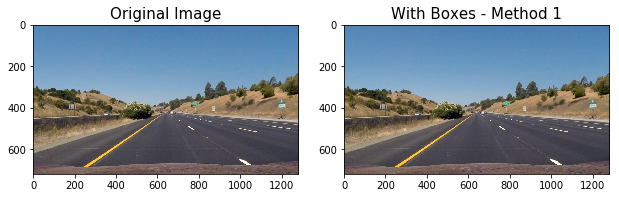

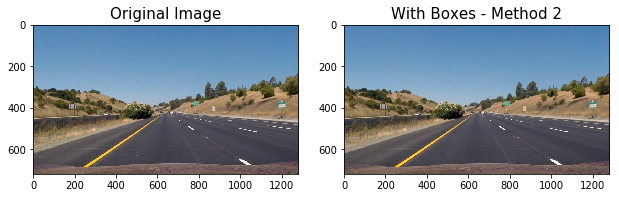

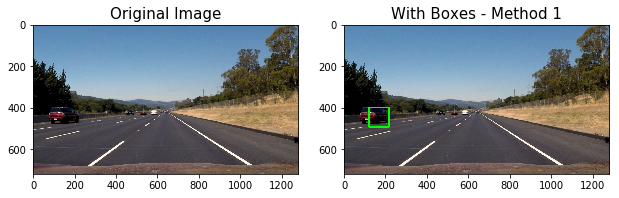

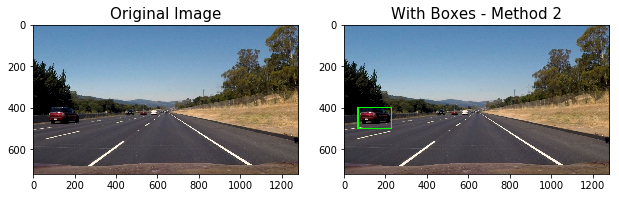

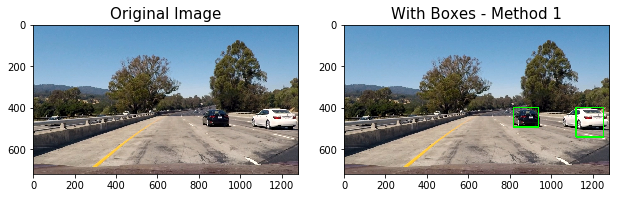

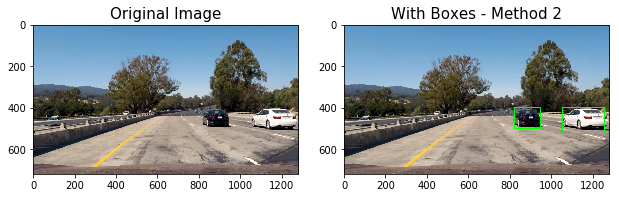

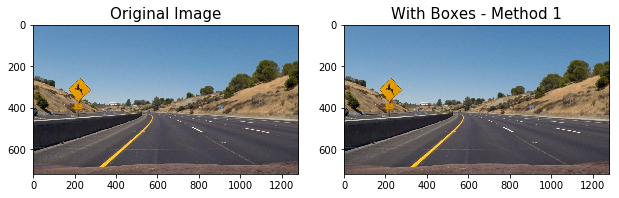

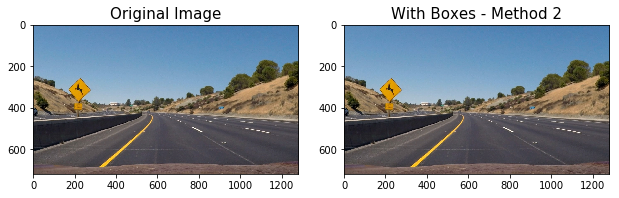

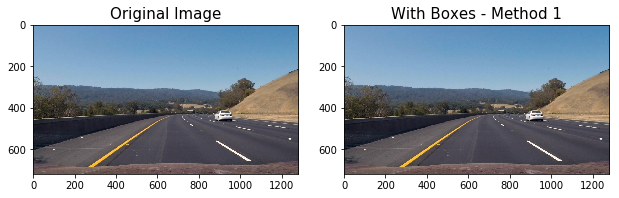

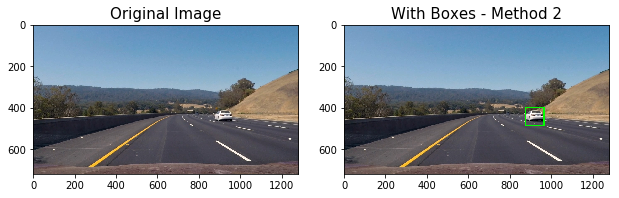

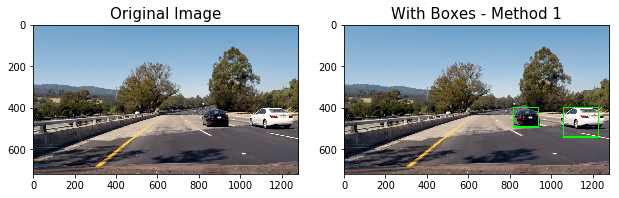

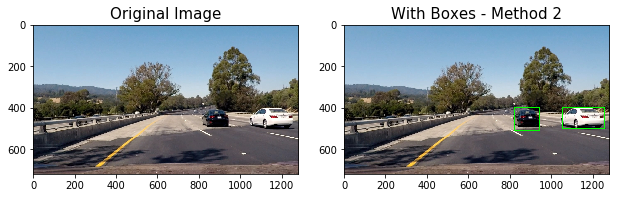

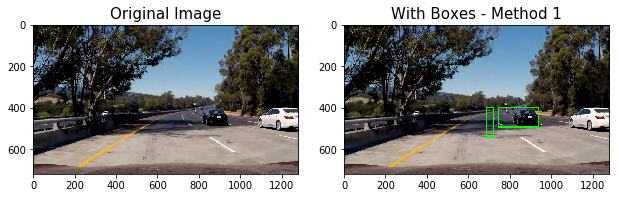

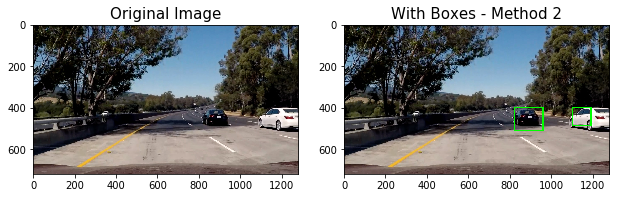

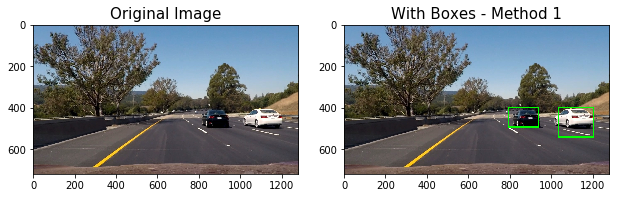

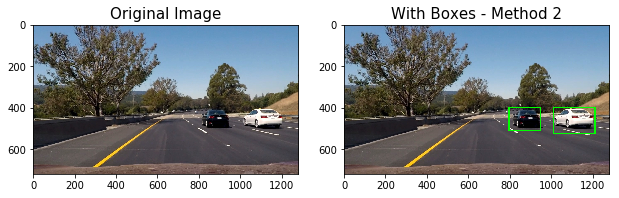

In [30]:
# Testing on images
dir_name = './test_images/'
output_folder = './output_images/'

# Browsing images
for img_name in os.listdir(dir_name):
    # Getting name without extension
    img_name_split = img_name.split(os.extsep)
    img_name_noext = img_name_split[0]
    img_name_ext = img_name_split[1]
    
    # Reading test image
    img = mpimg.imread(dir_name + img_name)
    
    # Selecting search method
    for method in (1,2):
        # Processing image
        img_draw = process_image(img, method=method, heat_thresh=1, plot_image=True)
        
        # Getting output file name
        file_suffix = '_boxes_' + str(method)
        
        # Saving output
        img_name_out = output_folder + img_name_noext + file_suffix + os.extsep + img_name_ext
        mpimg.imsave(img_name_out, img_draw)

### **6.3 Running pipeline on video stream**

In [31]:
# Importing libraries
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Initializing videa names
#input_names = ['project_video.mp4', 'challenge_video.mp4', 'harder_challenge_video.mp4']
input_names = ['project_video.mp4']
#input_names = ['challenge_video.mp4']
#input_names = ['harder_challenge_video.mp4']

for input_name in input_names:
    # Splitting input name
    input_name_split = input_name.split(os.extsep)
    input_name_noext = input_name_split[0]
    input_name_ext = input_name_split[1]

    # Setting output name
    output_name = input_name_noext + '_boxes_2' + os.extsep + input_name_ext

    # Initializing video
    input_clip = VideoFileClip(input_name)
    
    # Processing video
    output_clip = input_clip.fl_image(process_image)
    %time output_clip.write_videofile(output_name, audio=False)

[MoviePy] >>>> Building video project_video_boxes_2.mp4
[MoviePy] Writing video project_video_boxes_2.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [17:39<00:00,  1.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_boxes_2.mp4 

Wall time: 17min 41s
